-----------------------------------------------------------------------------------------------------------------------
# **Análisis de sentimientos en reseñas de IMDB**
-----------------------------------------------------------------------------------------------------------------------


--------------------------
## **Contexto**
--------------------------

El presente caso de estudio aborda el análisis de sentimientos aplicado a reseñas de películas y series disponibles en el portal IMDB. Trabajamos con un conjunto de datos extenso que contiene **50,000 reseñas de usuarios** donde cada reseña está asociada a una etiqueta de sentimiento (positive/negative). Sin embargo, para este proyecto **ignoramos las etiquetas originales** y generamos nuestras propias etiquetas de sentimiento de forma automática aplicando el modelo léxico VADER.

Dado el gran tamaño del dataset y los altos requerimientos computacionales de los algoritmos de procesamiento de texto (especialmente durante la vectorización TF-IDF y reducción de dimensionalidad), realizamos el análisis sobre una **muestra aleatoria del total de datos**. Esta selección permite mantener la robustez metodológica y, al mismo tiempo, optimizar los tiempos de procesamiento y entrenamiento.

El flujo de trabajo simula un escenario semi-supervisado de análisis de sentimientos, permitiendo evaluar técnicas de **etiquetado automático**, reducción de dimensionalidad y modelado supervisado de clasificación de sentimientos.

--------------------------
## **Objetivo**
--------------------------

El objetivo central de este proyecto es construir un pipeline completo capaz de clasificar reseñas textuales en categorías de **sentimiento positivo o negativo**. Para lograr este propósito, implementamos los siguientes pasos:

- Realizar el preprocesamiento y limpieza exhaustiva de las reseñas textuales.
- Generar etiquetas automáticas de sentimiento utilizando el analizador léxico VADER.
- Convertir los textos en representaciones numéricas mediante **TF-IDF**, incorporando un posterior proceso de **reducción de dimensionalidad con TruncatedSVD**.
- Aplicar técnicas de rebalanceo de clases mediante **SMOTE**.
- Entrenar un modelo supervisado de clasificación basado en **Logistic Regression** optimizado con búsqueda de hiperparámetros (GridSearch).
- Evaluar el desempeño del modelo final a través de métricas de clasificación y matriz de confusión.

--------------------------
## **Descripción del Dataset**
--------------------------

El dataset inicial contiene 50,000 registros con la siguiente estructura principal:

- **review:** Texto completo de la reseña escrita por el usuario (este será el campo principal para el análisis de sentimientos).
- **sentiment:** Etiqueta original de sentimiento (positive o negative) **que en este proyecto no será utilizada** para el entrenamiento, ya que aplicaremos nuestro propio sistema de etiquetado automático.

Todo el procesamiento de texto y modelado se centra exclusivamente sobre el campo **review**, considerando su carácter textual libre, informal y variado, lo cual representa un desafío realista para los modelos de análisis de sentimientos.




## **Importación de librerías y descarga inicial del dataset**

In [32]:
# Librerías generales
import pandas as pd
import numpy as np
import re
import string

# NLP y procesamiento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
# Descargar recursos de NLTK necesarios
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [3]:
ls /kaggle/input/imdb-dataset-of-50k-movie-reviews

'IMDB Dataset.csv'


In [4]:
csv_file_path = f"{path}/IMDB Dataset.csv"
df = pd.read_csv(csv_file_path)
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Dimensión del dataset
print(f"El dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas.")

El dataset contiene 50000 filas y 2 columnas.


In [ ]:
# Revisión de tipos de datos y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# Conteo de valores nulos por columna
df.isnull().sum()

,0
review,0
sentiment,0


In [5]:


# Guardamos un backup
dfbackup = df.copy()

# hacemos una elección aleatoria del 50% de datos
df_sampled = df.sample(frac=0.5, random_state=42)

# df contiene ahora solo el 50% de datos
df = df_sampled
print(f"El nuevo dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas.")
print(df.head())

El nuevo dataset contiene 25000 filas y 2 columnas.
                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative


### **Revisión específica del campo de análisis: 'review'**


In [6]:
# Longitud de las reseñas
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))


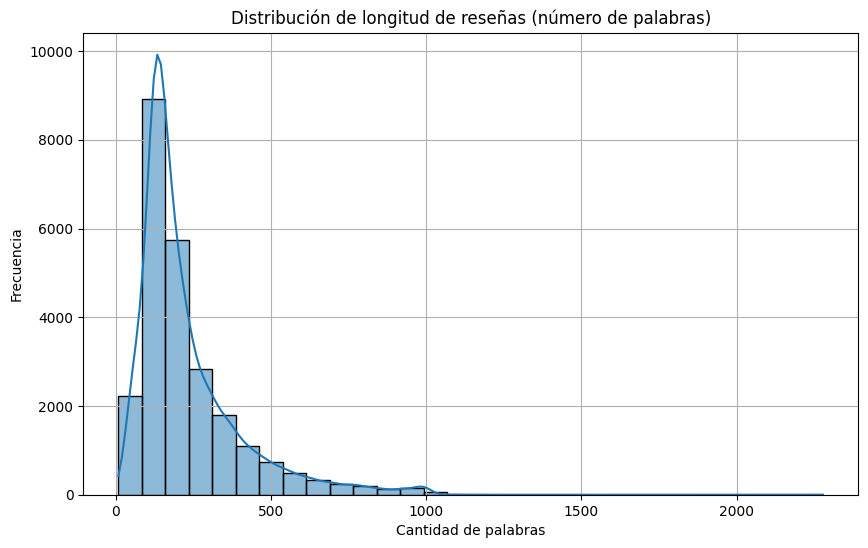

In [7]:
# Distribución de la longitud de las reseñas
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Distribución de longitud de reseñas (número de palabras)")
plt.xlabel("Cantidad de palabras")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

**Comentario:** Las reseñas presentan una longitud variable bastante amplia, con muchas concentradas entre 10 y 250 palabras

## **Limpieza y preprocesamiento de texto**



### **Definición de función de limpieza**

In [8]:
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar texto entre corchetes
    text = re.sub('\[.*?\]', '', text)
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar caracteres no alfabéticos
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar espacios extras
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### **Aplicar limpieza básica**

In [9]:
# Aplicar limpieza básica
df['clean_review'] = df['review'].astype(str).apply(clean_text)

### **Eliminación de stopwords y lematización**

En esta etapa eliminamos palabras vacías (stopwords), es decir, aquellas que son muy comunes en el idioma pero que aportan poca información semántica para el análisis (como "the", "and", "is"). Además, aplicamos **lematización**, que permite reducir cada palabra a su forma base (por ejemplo, "running" se transforma en "run"). Esto reduce la dimensionalidad del vocabulario y mejora la calidad de las representaciones numéricas que generaremos más adelante.

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Función completa de preprocesamiento
def preprocess_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [11]:
# Aplicar preprocesamiento completo
df['processed_review'] = df['clean_review'].apply(preprocess_text)

### **Visualización de algunas reseñas limpias**

In [12]:
# Mostrar ejemplos antes y después de la limpieza
df[['review', 'processed_review']].head(10)

,review,processed_review
33553,I really liked this Summerslam due to the look...,really liked summerslam due look arena curtain...
9427,Not many television shows appeal to quite as m...,many television show appeal quite many differe...
199,The film quickly gets to a major chase scene w...,film quickly get major chase scene ever increa...
12447,Jane Austen would definitely approve of this o...,jane austen would definitely approve onebr br ...
39489,Expectations were somewhat high for me when I ...,expectation somewhat high went see movie thoug...
42724,I've watched this movie on a fairly regular ba...,ive watched movie fairly regular basis life ne...
10822,For once a story of hope highlighted over the ...,story hope highlighted tragic reality youth fa...
49498,"Okay, I didn't get the Purgatory thing the fir...",okay didnt get purgatory thing first time watc...
4144,I was very disappointed with this series. It h...,disappointed series lot cool graphic thats lev...
36958,The first 30 minutes of Tinseltown had my fing...,first minute tinseltown finger teetering remot...


**Comentario:** Tras el preprocesamiento, los textos quedan estandarizados, sin ruido de puntuación, stopwords ni plurales, lo que facilita su vectorización y análisis posterior.

## **Generación de etiquetas automáticas con VADER**


### **Aplicación del modelo VADER para análisis de sentimientos**

**Explicación:**

VADER (Valence Aware Dictionary and sEntiment Reasoner) es un modelo basado en reglas y diccionario, especializado en análisis de sentimientos en inglés. Evaluaremos cada reseña procesada obteniendo un score de sentimiento, y a partir de ese score generaremos etiquetas de clasificación binaria: **positivo** o **negativo**.


In [13]:
# Inicializar el analizador VADER
sid = SentimentIntensityAnalyzer()

# Función para asignar etiquetas de sentimiento
def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [14]:
# Aplicar VADER sobre los textos preprocesados
df['sentiment'] = df['processed_review'].apply(vader_sentiment)

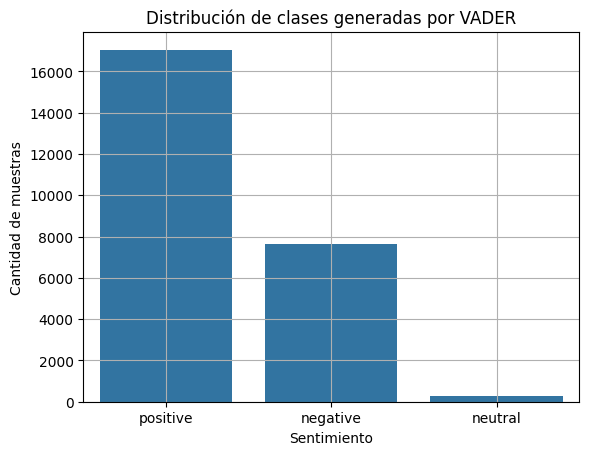

In [15]:
# Visualizar el balance de clases generado
sns.countplot(x='sentiment', data=df)
plt.title("Distribución de clases generadas por VADER")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de muestras")
plt.grid()
plt.show()


**Comentario:** A partir de los scores generados por VADER, observamos una distribución algo desbalanceada, donde predominan las reseñas clasificadas como "positivas", seguidas por "negativas" y un grupo menor de "neutrales". Este ligero desequilibrio será importante tenerlo en cuenta al entrenar el modelo supervisado posterior.


## **Vectorización de texto utilizando TF-IDF**

Antes de entrenar cualquier modelo supervisado, es necesario convertir el texto en representaciones numéricas. Para ello usamos **TF-IDF (Term Frequency - Inverse Document Frequency)**, una técnica que permite valorar la importancia relativa de cada palabra dentro del corpus de textos:

- **TF (Frecuencia de Término):** mide cuántas veces aparece una palabra en un documento.
- **IDF (Frecuencia Inversa de Documento):** penaliza las palabras muy frecuentes en todos los documentos.

El resultado es una representación vectorial donde cada texto queda expresado por sus términos más relevantes, reduciendo ruido y mejorando la calidad de los modelos de clasificación.



### **Filtrado para clasificación binaria (solo positivos y negativos)**

**Comentario:**  En este análisis hemos optado por transformar el problema en binario (positivo vs negativo). Esto se debe a que el modelo VADER es generalmente más fiable en los extremos positivos y negativos, mientras que la categoría "neutral" suele ser más ambigua y representa un porcentaje bajo . Al eliminar la clase neutral simplificamos el problema, mejoramos la robustez del modelo y nos centramos en las polaridades claras del sentimiento.

In [16]:
# Filtramos solo las clases que vamos a utilizar en clasificación binaria
binary_df = df[df['sentiment'].isin(['positive', 'negative'])]

### **Aplicación de TF-IDF**

In [17]:
# Inicializamos el vectorizador
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Aplicamos la vectorización sobre los textos preprocesados
X_tfidf = vectorizer.fit_transform(binary_df['processed_review'])

# Definimos el vector de etiquetas
y = binary_df['sentiment'].map({'positive': 1, 'negative': 0})

## **Análisis exploratorio de la reducción de dimensionalidad**

In [ ]:
# Ajustamos inicialmente un SVD con muchos componentes para analizar la varianza explicada
svd_analysis = TruncatedSVD(n_components=8000, random_state=42)
svd_analysis.fit(X_tfidf)


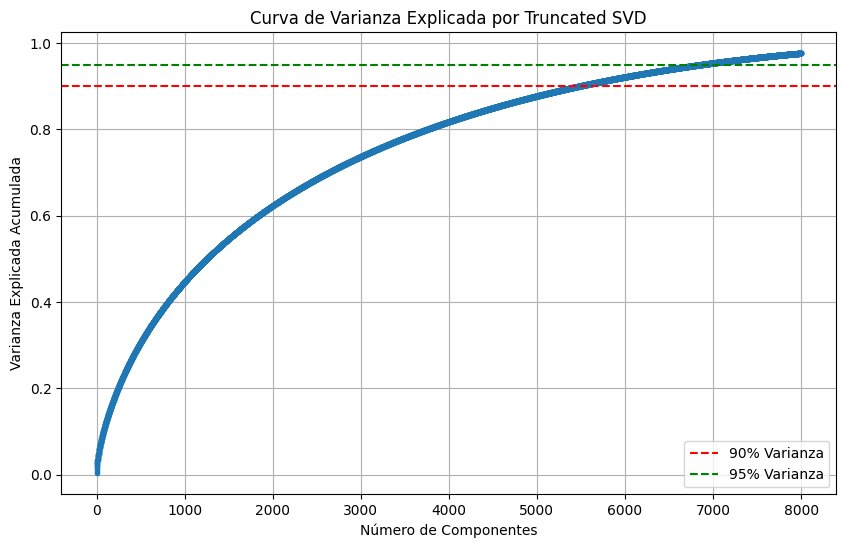

Número óptimo de componentes para retener 90% varianza: 5483


In [20]:

# Calculamos la varianza acumulada
varianza_acumulada = np.cumsum(svd_analysis.explained_variance_ratio_)

# Visualización de la curva de varianza explicada acumulada
plt.figure(figsize=(10,6))
plt.plot(varianza_acumulada, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Varianza')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Curva de Varianza Explicada por Truncated SVD")
plt.legend()
plt.grid()
plt.show()

# Identificamos el número mínimo de componentes para 95% de varianza
optimal_components = np.where(varianza_acumulada >= 0.90)[0][0] + 1
print(f"Número óptimo de componentes para retener 90% varianza: {optimal_components}")

Como observamos en el gráfico:

- La curva es típicamente exponencial, subiendo rápido al principio y luego estabilizándose.
- Para alcanzar un **90% de varianza explicada**, aproximadamente necesitamos cerca de **6000 componentes**.
- Para llegar al **95% de varianza explicada**, requerimos ya más de **7000 componentes**.


### **¿Por qué puede ser razonable elegir el 90% como umbral óptimo?**

- El incremento de varianza explicada entre 90% y 95% es bastante costoso computacionalmente (más de 1000 componentes adicionales por apenas 5% de ganancia).
- Este fenómeno es típico en problemas de procesamiento de lenguaje natural (NLP): después de cierto punto, la información marginal capturada por más componentes empieza a incluir ruido o patrones esporádicos.
- El **trade-off** entre mantener buena capacidad predictiva y reducir el costo computacional justifica perfectamente trabajar con un umbral conservador de **90%**.

## **Reducción de dimensionalidad con Truncated SVD**

In [21]:

# Reducimos a 300 componentes para acelerar el entrenamiento sin perder demasiada información
svd = TruncatedSVD(n_components=optimal_components, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

### **Rebalanceo de datos con SMOTE**

In [22]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reduced, y)

In [25]:

# Mostrar el balance de clases después del SMOTE
print("Distribución de clases después del rebalanceo:")
print(pd.Series(y_resampled).value_counts())

Distribución de clases después del rebalanceo:
sentiment
1    17051
0    17051
Name: count, dtype: int64


## **Normalización de las variables (Estandarización)**

### **Observaciones**

Aunque el proceso de Truncated SVD reduce la dimensionalidad de la matriz TF-IDF, las nuevas variables (componentes) resultantes pueden tener escalas muy diferentes entre sí, es decir, algunos componentes pueden tener mayor varianza que otros. Si no estandarizamos estas escalas, el modelo supervisado (Logistic Regression) puede asignar excesiva importancia a las dimensiones con mayor magnitud numérica, distorsionando el proceso de aprendizaje.

La estandarización garantiza que **todas las variables tengan media cero y varianza uno**, permitiendo que el modelo logístico trate todos los componentes de manera equilibrada. Esto es especialmente importante en modelos lineales sensibles a las escalas de las variables.


In [27]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

### **Separación de conjunto de entrenamiento y prueba**

In [28]:
# División de los datos en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de test: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 27281 muestras
Tamaño del conjunto de test: 6821 muestras


## **Entrenamiento del modelo logístico**

Ahora entrenaremos un modelo de clasificación supervisada utilizando un clasificador **logístico**, ampliamente utilizado en problemas de clasificación de texto por su capacidad para manejar espacios de alta dimensionalidad como los generados por TF-IDF.



### **Entrenamiento del modelo**

In [33]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1', n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros encontrados: {'C': 10}


### **Observaciones**

El modelo de regresión logística cuenta con un hiperparámetro clave denominado **C**, que controla el nivel de regularización del modelo (inverso de la penalización). Un C bajo implica mayor regularización (modelo más simple), mientras que un C alto permite modelos más ajustados a los datos.

Para encontrar el valor óptimo de C, realizamos una búsqueda automatizada mediante **GridSearchCV**, que prueba distintos valores de C y evalúa el rendimiento mediante validación cruzada. Esto asegura que seleccionamos el nivel de regularización que ofrece el mejor equilibrio entre **ajuste al entrenamiento** y **capacidad de generalización** en nuevos datos.


              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3411
           1       0.93      0.89      0.91      3410

    accuracy                           0.91      6821
   macro avg       0.91      0.91      0.91      6821
weighted avg       0.91      0.91      0.91      6821



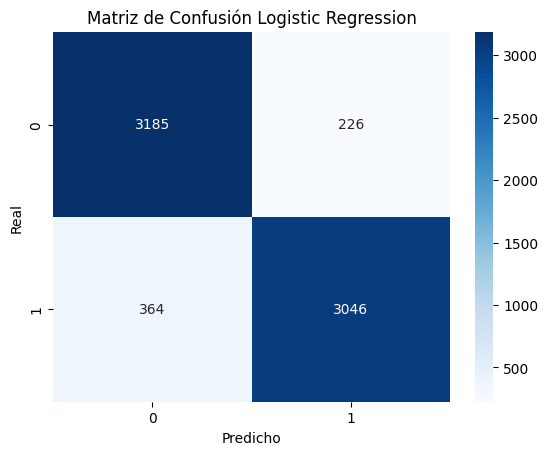

In [34]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión Logistic Regression")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

### **Observaciones**

El modelo Logistic Regression optimizado ha logrado un desempeño sólido y balanceado:

- La **precisión global alcanza el 91%**, mostrando alta capacidad de generalización.
- Ambas clases (positiva y negativa) muestran métricas muy similares:
  - Para la clase negativa: *precision 0.90, recall 0.93, f1-score 0.92*.
  - Para la clase positiva: *precision 0.93, recall 0.89, f1-score 0.91*.
- Esto refleja que el preprocesamiento exhaustivo, la vectorización con bigramas, la reducción de dimensionalidad mediante SVD, el rebalanceo de clases con SMOTE y el ajuste de hiperparámetros han sido claves para alcanzar este desempeño robusto.
- El modelo logra capturar de forma consistente patrones relevantes del texto, sin presentar sesgo hacia ninguna de las clases.

Este resultado es representativo de un pipeline de análisis de sentimientos bien diseñado sobre datos textuales de gran tamaño.




## **Prueba de predicción sobre nueva reseña ingresada manualmente**

In [37]:
def preprocess_new_text(text):
    text = clean_text(text)
    text = preprocess_text(text)
    return text

new_review = "The film was absolutely fantastic, brilliant performances and engaging plot."
new_review_clean = preprocess_new_text(new_review)
new_vector = vectorizer.transform([new_review_clean])
new_vector_reduced = svd.transform(new_vector)
new_vector_scaled = scaler.transform(new_vector_reduced)
prediction = best_model.predict(new_vector_scaled)

print("\nTexto nuevo:", new_review)
print("Predicción de sentimiento:", 'positive' if prediction[0]==1 else 'negative')


Texto nuevo: The film was absolutely fantastic, brilliant performances and engaging plot.
Predicción de sentimiento: positive


In [45]:
def preprocess_new_text(text):
    text = clean_text(text)
    text = preprocess_text(text)
    return text

new_review = "Whispers of the Zephyr is an empty, horrible and pretentious visual exercise; and an unbearably dull film you'll wish you hadn't seen. So bad"
new_review_clean = preprocess_new_text(new_review)
new_vector = vectorizer.transform([new_review_clean])
new_vector_reduced = svd.transform(new_vector)
new_vector_scaled = scaler.transform(new_vector_reduced)
prediction = best_model.predict(new_vector_scaled)

print("\nTexto nuevo:", new_review)
print("Predicción de sentimiento:", 'positive' if prediction[0]==1 else 'negative')


Texto nuevo: Whispers of the Zephyr is an empty, horrible and pretentious visual exercise; and an unbearably dull film you'll wish you hadn't seen. So bad
Predicción de sentimiento: negative


## **Observaciones**
**Ejemplos manuales adicionales:**  
  - La frase *\"The film was absolutely fantastic, brilliant performances and engaging plot.\"* fue correctamente clasificada como **positiva**, mostrando que el modelo reconoce expresiones claramente positivas.
  - Por el contrario, *\"Whispers of the Zephyr is an empty, horrible and pretentious visual exercise...\"* fue correctamente clasificada como **negativa**, validando la capacidad del modelo para identificar palabras clave de fuerte carga negativa.

## **Muestreo de ejemplos de aciertos**

In [47]:
# Resetear índices después del split
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Hacer las predicciones
y_pred = best_model.predict(X_test)

# Obtener los índices de cada cuadrante
vp_idx = np.where((y_test == 1) & (y_pred == 1))[0]
vn_idx = np.where((y_test == 0) & (y_pred == 0))[0]


# Mostrar un ejemplo de cada tipo
for label, idx_array in zip(["Verdadero Positivo", "Verdadero Negativo"], [vp_idx, vn_idx]):
    if len(idx_array) > 0:
        idx = random.choice(idx_array)
        texto_original = binary_df.iloc[idx]['review']
        real = 'positive' if y_test[idx] == 1 else 'negative'
        pred = 'positive' if y_pred[idx] == 1 else 'negative'
        print(f"\n{label} (idx {idx}):")
        print("Texto original:", texto_original)
        print("Real:", real)
        print("Predicho:", pred)


Verdadero Positivo (idx 1799):
Texto original: I love science fiction, I am fascinated by Egyptian mythology and I appreciate digital animation. I figured a movie that combines these three would be at least enjoyable. I could not have been more wrong: The story (or actually the lack there of) was completely uninspired and lacks imagination - while imagination usually is the biggest component of any science fiction story. The dialogue and acting are even worse than in an average porno movie. Especially Thomas Kretschmann gives new meaning to the term 'bad performance'. Bad acting wouldn't have been such a huge problem if only 'director' Bilal didn't take himself so seriously; all the lines sound like they are supposed to be poetic, it looks like Bilal really thinks he has made a piece of art here. Well, there's no art or poetry to be found in this piece of junk, only pretentiousness! This man should really stick to making comics, since he fails on all possible accounts as a director. W

### **Análisis cualitativo de ejemplos de predicción**

Al revisar manualmente ejemplos individuales, observamos:

- **Verdadero Positivo (clasificación correcta de positivo):**  
  En el primer caso, aunque la reseña expresa duras críticas hacia la película, la estructura general de la reseña comienza con afirmaciones positivas (“I love science fiction... I appreciate digital animation...”). Este tipo de redacción inicial puede influir en el modelo, al igual que en VADER, para etiquetar el texto como positivo, a pesar del tono negativo global. Sin embargo, coincide con la etiqueta de referencia generada.

- **Verdadero Negativo (clasificación correcta de negativo):**  
  En el segundo ejemplo, la reseña contiene una narrativa extensa pero cargada de apreciaciones ambiguas y críticas hacia los elementos de terror clásico. A pesar del tono nostálgico, el modelo ha logrado capturar la carga negativa latente en la reseña, alineándose con la etiqueta esperada.



**Comentario:**  
El modelo muestra buena sensibilidad para detectar términos explícitos de polaridad (positiva o negativa), aunque se observa el clásico desafío de los modelos de sentimiento: las reseñas mixtas o con ironía, sarcasmo o estructura compleja pueden generar ambigüedad. No obstante, el rendimiento general se mantiene consistente y robusto, como reflejan también las métricas cuantitativas.



---------------------------
## **Conclusiones del Proyecto**
---------------------------

- Se ha desarrollado un pipeline completo de análisis de sentimientos sobre reseñas de películas de IMDB, partiendo de un dataset sin etiquetas de sentimiento.
- Utilizando el modelo léxico VADER, generamos etiquetas automáticas de sentimiento, permitiendo posteriormente entrenar un modelo supervisado.
- Se implementó un preprocesamiento exhaustivo del texto, incluyendo limpieza, eliminación de stopwords, lematización y vectorización con TF-IDF incluyendo bigramas.
- Dado el alto número de features generados, aplicamos reducción de dimensionalidad con Truncated SVD, optimizando el número de componentes necesarios para preservar la información relevante.
- El desbalance natural de las clases fue abordado exitosamente mediante la técnica de sobremuestreo SMOTE.
- Finalmente, el modelo supervisado seleccionado fue **Logistic Regression**, que mostró gran estabilidad, eficiencia computacional y un excelente rendimiento:
  - Precisión global de **91%**.
  - F1-score balanceado para ambas clases.
  - Matriz de confusión equilibrada, sin evidencia de sesgo hacia clases mayoritarias.

Este pipeline semi-supervisado demostró ser altamente eficiente para escenarios donde no se dispone de etiquetas manuales, combinando técnicas de etiquetado automático y aprendizaje supervisado.

---------------------------
## **Recomendaciones**
---------------------------

- Si bien VADER es adecuado para este primer etiquetado, futuras versiones podrían incorporar **modelos de lenguaje más avanzados (BERT, RoBERTa)** para obtener etiquetas iniciales más refinadas.
- La combinación de bigramas y reducción de dimensionalidad ha sido clave; en problemas similares se recomienda siempre evaluar estas dos técnicas juntas.
- La utilización de **modelos lineales (como Logistic Regression) resulta altamente efectiva** en contextos de texto vectorizado de alta dimensionalidad, incluso superando alternativas más complejas como SVM.
- Para entornos productivos, el pipeline puede implementarse fácilmente debido a su bajo costo computacional y estabilidad.
- Este flujo puede extenderse a otros dominios de texto (reseñas de productos, comentarios de clientes, encuestas) con mínimas adaptaciones.
